In [1]:
# Import necessary libraries

# For basic operations
import pandas as pd
import numpy as np

# For loading twitter data
!pip install tweepy
import tweepy        # https://github.com/tweepy/tweepy
import json

# For word tokenization
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# For handling stopwords
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords

# For wordcloud generator
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For visualisation
from plotly import graph_objs as go
from plotly.offline import iplot
import networkx as nx
import seaborn as sns

# For sentiment analysis
!pip install textblob
from textblob import TextBlob

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Twitter API Configuration
api_key = 'your_api_key'
api_secret = 'your_api_secret'
access_token = 'your_access_token'
access_token_secret = 'your_token_secret'

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [3]:
# Define parameter
tweet_keywords = 'dune'
tweet_filter = '-filter:retweets' # Exclude retweets because they are duplicates
end_date = '2021-10-27'
tweets = tweepy.Cursor(api.search_tweets, q=tweet_keywords+" "+tweet_filter, until=end_date, count=100, lang='en', tweet_mode='extended').items()

# Create a function to fetch tweets
def get_tweets(tweet_keywords):
    tweet_list = []
    iteration_count = 0
    for tweet in tweets:
        tweet_dict = {}
        tweet_dict['tweet_id'] = tweet.id_str
        tweet_dict['tweet'] = tweet.full_text
        tweet_dict['created_at'] = tweet.created_at
        tweet_dict['like_count'] = tweet.favorite_count
        tweet_dict['retweet_count'] = tweet.retweet_count
        tweet_dict['user_id'] = tweet.user.id_str
        tweet_dict['username'] = tweet.user.screen_name
        tweet_dict['verified_user'] = tweet.user.verified
        tweet_dict['followers_count'] = tweet.user.followers_count
        tweet_dict['friends_count'] = tweet.user.friends_count
        tweet_dict['in_reply_to_username'] = tweet.in_reply_to_screen_name
        
        tweet_list.append(tweet_dict)
        iteration_count += 1
        
        if iteration_count == 10000: # Twitter only allows us to extract 100 tweets per request, so we add this function to get 10K tweets in total
            break
        else:
            pass
    return tweet_list

In [4]:
# Load dataset
all_tweets = get_tweets(tweet_keywords)
tweet_df = pd.DataFrame(all_tweets)
tweet_df.head()

,tweet_id,tweet,created_at,like_count,retweet_count,user_id,username,verified_user,followers_count,friends_count,in_reply_to_username
0,1453149440630460420,Dune is such a dumb movie wtf,2021-10-26 23:59:59+00:00,0,0,3329109531,daannying,False,354,326,None
1,1453149426143346694,"If Dune really is ""Star Wars for Grown-ups"" th...",2021-10-26 23:59:56+00:00,8,3,3700293076,DLJGameReviews,False,265,95,None
2,1453149425577103360,"""Unseen but ever-present forces make Arrakis a...",2021-10-26 23:59:55+00:00,0,0,49771314,Sauliloquy1,True,2567,1558,None
3,1453149418190819329,should i read DUNE the book? 🤔 I can't wait fo...,2021-10-26 23:59:54+00:00,0,0,1070862485652033536,raelleshand,False,940,185,None
4,1453149414328094722,Dune is excellent. I already want to watch it ...,2021-10-26 23:59:53+00:00,14,0,715331576633032704,clayroutledge,False,19387,749,None


# Exploratory Data Analysis

In [8]:
# Get tweets with the highest retweet_count
highest_retweet_count = tweet_df.nlargest(10,['retweet_count'])
highest_retweet_count

,tweet_id,tweet,created_at,like_count,retweet_count,user_id,username,verified_user,followers_count,friends_count,in_reply_to_username
4211,1453128825991225345,Denis Villeneuve really made \n\nIncendies \nP...,2021-10-26 22:38:04+00:00,27516,3645,462453177,Brodeyy_51,False,2680,1520,None
8274,1453112403286106113,Please go see Dune. 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥 let the spice flow,2021-10-26 21:32:49+00:00,12321,1091,243287822,KidCudi,True,2734946,15,None
9015,1453109637931102211,#Dune Poster in the US. #Dune po...,2021-10-26 21:21:49+00:00,6617,735,4294577954,UpToTASK,False,16190,1255,None
2554,1453136743256018945,dune was so good https://t.co/AVMXDltivB,2021-10-26 23:09:32+00:00,4693,725,52001582,gabebergado,True,13288,1196,None
7967,1453113537304268805,dune is about the beauty of islam. mashallah,2021-10-26 21:37:19+00:00,8267,485,17109158,MargBarAmerica,False,41249,1255,None
3396,1453132706594893824,Dune (2021) https://t.co/ixzcrjQBYu,2021-10-26 22:53:29+00:00,4453,407,86101978,hansmollman,True,76553,2980,None
1897,1453139844968771584,loved this scene from Dune https://t.co/iWAA6b...,2021-10-26 23:21:51+00:00,3305,312,104818552,VinMan17,True,178025,1443,None
8526,1453111397143900160,nobody else is dune it like zendaya as chani k...,2021-10-26 21:28:49+00:00,1297,256,1431874106694115331,ruesholland,False,687,422,None
3044,1453134346638950410,Really well-explored review of Villaneuve's sc...,2021-10-26 23:00:00+00:00,684,211,24854898,SanaSaeed,True,90549,868,None
5603,1453122879181230090,Dune 2: We're Dune it again.,2021-10-26 22:14:26+00:00,722,194,1145695394,sofarrsogud,False,19939,6757,None


In [9]:
# Get tweets with the highest like_count
highest_like_count = tweet_df.nlargest(10,['like_count'])
highest_like_count

,tweet_id,tweet,created_at,like_count,retweet_count,user_id,username,verified_user,followers_count,friends_count,in_reply_to_username
4211,1453128825991225345,Denis Villeneuve really made \n\nIncendies \nP...,2021-10-26 22:38:04+00:00,27516,3645,462453177,Brodeyy_51,False,2680,1520,None
8274,1453112403286106113,Please go see Dune. 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥 let the spice flow,2021-10-26 21:32:49+00:00,12321,1091,243287822,KidCudi,True,2734946,15,None
7967,1453113537304268805,dune is about the beauty of islam. mashallah,2021-10-26 21:37:19+00:00,8267,485,17109158,MargBarAmerica,False,41249,1255,None
9015,1453109637931102211,#Dune Poster in the US. #Dune po...,2021-10-26 21:21:49+00:00,6617,735,4294577954,UpToTASK,False,16190,1255,None
2554,1453136743256018945,dune was so good https://t.co/AVMXDltivB,2021-10-26 23:09:32+00:00,4693,725,52001582,gabebergado,True,13288,1196,None
3396,1453132706594893824,Dune (2021) https://t.co/ixzcrjQBYu,2021-10-26 22:53:29+00:00,4453,407,86101978,hansmollman,True,76553,2980,None
252,1453148149254557698,I could tell Dune was getting a sequel from th...,2021-10-26 23:54:51+00:00,3773,114,28483093,Reddsaidit,True,91552,3357,None
1897,1453139844968771584,loved this scene from Dune https://t.co/iWAA6b...,2021-10-26 23:21:51+00:00,3305,312,104818552,VinMan17,True,178025,1443,None
3921,1453130269305630725,Dune 2 should be set on an ice planet and Dune...,2021-10-26 22:43:48+00:00,2758,108,2999158160,pixelatedboat,False,327970,900,None
6210,1453120401135976448,#Dune was watched by 1.9M households on openin...,2021-10-26 22:04:35+00:00,1687,185,932786452739407872,CultureCrave,True,320516,92,None


# Mapping sentiment polarity to each tweet using TextBlob

In [10]:
# Apply TextBlob
tweet_df['sentiment_score'] = tweet_df['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

In [11]:
# Mapping the interpretation of the sentiment_score
interpretation_list=[]
for i in tweet_df['sentiment_score']:
    if i > 0:
        interpretation_list.append('Positive')
    elif i == 0:
        interpretation_list.append('Neutral')
    elif i < 0:
        interpretation_list.append('Negative')

In [9]:
# Add a new column for sentiment score interpretation      
tweet_df['sentiment_category'] = interpretation_list

Text(0.5, 1.0, 'Sentiment score distribution')

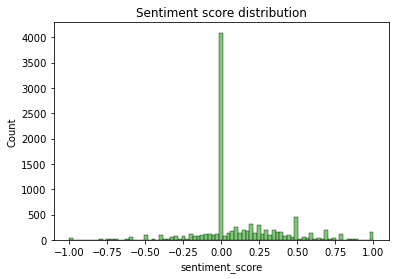

In [10]:
# Show sentiment score distribution
sns.histplot(data=tweet_df, x=tweet_df['sentiment_score'], color = '#50B848').set_title('Sentiment score distribution')

In [12]:
# Compute number of tweets by sentiment_category
tweet_df['dummy'] = 1
colors = ['crimson','gray','green']

sentiment_agg_df=tweet_df.groupby('sentiment_category', as_index=0).agg({'dummy':sum}).rename(columns={"dummy": "tweet_count"})
fig_sentiment = go.Figure(data=[go.Bar(
    x=sentiment_agg_df['sentiment_category'],
    y=sentiment_agg_df['tweet_count'],
    marker_color=colors
)])
fig_sentiment.update_layout(title_text='Sentiment category of Dune tweets')
fig_sentiment.show()

# Understanding the most frequent words appeared on Twitter

In [13]:
# Create a function to generate a wordcloud
def generate_wordcloud(col):
    # Word tokenization
    tweet_text_list = col.tolist()
    tweet_string = " ".join(tweet_text_list)
    tokens = word_tokenize(tweet_string)
    
    # Removing stopwords
    lowercase_tokens = [token.lower() for token in tokens]
    additional_stopwords = ['dune','rt', 'https', '@',"'","`","...",",","n't",".","'s","’","'m","``","•","''","”","“","'ve","'ll",".."]
    stopwords_list = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) + additional_stopwords)
    filtered_text = [token for token in lowercase_tokens if not token in stopwords_list]
    
    # Generate most common words
    fdist = FreqDist(filtered_text)
    most_common_words = fdist.most_common(100)
    print("Top 100 most common words")
    print(most_common_words)
    
    # Generate wordcloud
    simple_frequencies_dict = Counter(filtered_text)
    wordcloud = WordCloud(width=800,
                          height=400,
                          max_font_size=160,
                          background_color='white',
                          colormap='Dark2',
                          random_state=7).generate_from_frequencies(simple_frequencies_dict)
    plt.figure(figsize=(20,12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Top 100 most common words
[('part', 1229), ('movie', 1066), ('like', 880), ('see', 687), ('good', 614), ('watch', 572), ('one', 527), ('two', 526), ('time', 459), ('really', 436), ('book', 418), ('get', 410), ('sequel', 405), ('read', 361), ('people', 361), ('watching', 357), ('film', 355), ('would', 354), ('know', 333), ('first', 329), ('going', 327), ('think', 316), ('na', 298), ('new', 297), ('seen', 293), ('dunemovie', 285), ('got', 279), ('watched', 275), ('even', 272), ('go', 269), ('much', 250), ('wait', 249), ('great', 245), ('movies', 241), ('amp', 230), ('way', 226), ('love', 226), ('want', 224), ('gon', 224), ('villeneuve', 223), ('2021', 223), ('still', 218), ('zendaya', 213), ('make', 208), ('could', 204), ('saw', 203), ('need', 202), ('books', 200), ('getting', 199), ('1x', 198), ('denis', 196), ('better', 190), ('also', 187), ('well', 185), ('paul', 182), ('2023', 181), ('say', 179), ('made', 178), ('spice', 178), ('years', 178), ('right', 172), ('seeing', 171), ('yet', 

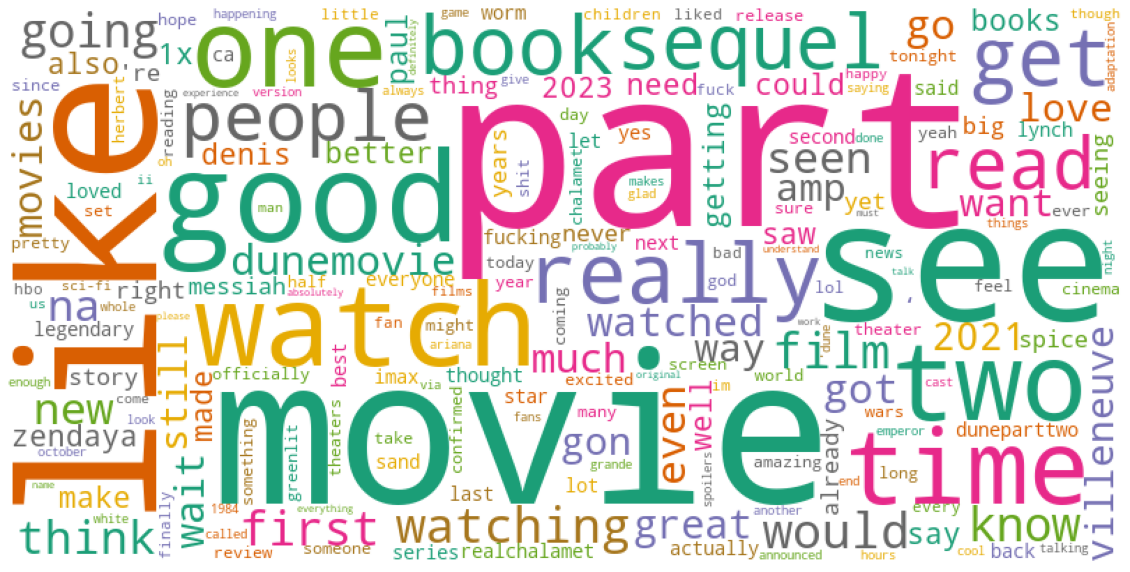

In [14]:
# Generate wordcloud for all tweets
generate_wordcloud(tweet_df['tweet'])

# Visualising Interactions on Twitter

In [15]:
# Create a function to draw the network
def get_network(df, pop_source_th, pop_target_th, edge_th, pop_person_th):
    # Define a parameter to identify most popular people with the highest engagements (replies)
    popular_sources_df = df.groupby('source', as_index=False).agg({'target':pd.Series.nunique})
    popular_sources_df = popular_sources_df[popular_sources_df['target'] >= pop_source_th]
    popular_sources_list = popular_sources_df['source'].tolist()

    # Define a parameter to identify most popular targets
    popular_targets_df = df.groupby('target', as_index=False).count()
    popular_targets_df = popular_targets_df[popular_targets_df['source'] >= pop_target_th]
    popular_targets_list = popular_targets_df['target'].tolist()

    # Step 1: Create a dataframe that only contains popular sources and targets
    # We are doing this because we have a large dataset, showing too many networks will not be very insightful
    # So, we filter the original dataframe as follows:
    filtered_network_df = df[df['source'].isin(popular_sources_list) & df['target'].isin(popular_targets_list)]
    
    # Step 2: Create graph g for network visualisation
    # We will use this as an for the network visualisation
    g = nx.from_pandas_edgelist(filtered_network_df, source='source', target='target') 

    # Step 3: Create unique lists of the source and target
    # We will use this as inputs for the network visualisation
    sources = list(filtered_network_df['source'].unique())
    targets = list(filtered_network_df['target'].unique())
    
    # Step 4: Create separate dataframe to extract the list of edges
    # We need this to be able to customise the edge visualisation
    network_edges_df = filtered_network_df.copy()
    network_edges_df['count_edges'] = network_edges_df.groupby(['source','target'])['target'].transform('size')
    
    # Step 5: Create tuples from the edges data
    # We need this to be able to customise the edge visualisation
    # We are going to create two types of edge:
    # 1) thickEdge for popular edges (High interaction on Twitter);
    # 2) thinEdge for non-popular edges (Low interaction on Twitter)
    thickEdge_subset_df = network_edges_df[['source','target']][network_edges_df['count_edges'] >= edge_th]
    thickEdge_tuples = [tuple(x) for x in thickEdge_subset_df.to_numpy()]
    thick_edge = [(u,v) for (u,v,d) in g.edges(data = True) if (u,v) in thickEdge_tuples]
    
    thinEdge_subset_df = network_edges_df[['source','target']][network_edges_df['count_edges'] < edge_th]
    thinEdge_tuples = [tuple(x) for x in thinEdge_subset_df.to_numpy()]
    thin_edge = [(u,v) for (u,v,d) in g.edges(data = True) if (u,v) in thinEdge_tuples]
    
    # Step 6: Now, we start drawing the netrok. Firstly, define the figure size of the network
    plt.figure(figsize=(30, 30))

    # Step 7: Define necessary inputs for network visualisation
    layout = nx.spring_layout(g, k = 0.4, seed=1, iterations=10)
    popular_persons = [person for person in sources if g.degree(person) >= pop_person_th]
    source_size_popular_persons = [g.degree(person)*500 for person in popular_persons]
    non_popular_persons_source = [person for person in sources if person not in popular_persons]
    non_popular_persons_target = [person for person in targets if person not in popular_persons]
    source_size = [g.degree(person)*500 for person in sources]

    # Step 8: Draw all nodes
    nx.draw_networkx_nodes(g, 
                           layout, 
                           nodelist=sources,
                           node_color='lightsteelblue',
                           node_size=source_size
                           )

    # Step 9: Draw nodes of popular sources
    nx.draw_networkx_nodes(g,
                           layout,
                           nodelist=popular_persons,
                           node_color='gold',
                           node_size=source_size_popular_persons)

    # Step 10: Draw network edges
    nx.draw_networkx_edges(g, layout, width=4, edgelist=thick_edge, edge_color="gold")
    nx.draw_networkx_edges(g, layout, width=1, edgelist=thin_edge, edge_color="grey")

    # Step 11: Draw node labels
    nx.draw_networkx_labels(g, layout, {n: n for n in popular_persons}, font_size=28, font_family='Monospace', font_weight='bold')
    nx.draw_networkx_labels(g, layout, {n: n for n in non_popular_persons_source}, font_family='Monospace', font_size=12)
    nx.draw_networkx_labels(g, layout, {n: n for n in non_popular_persons_target}, font_family='Monospace', font_size=12)

    plt.axis('off')
    plt.show()

In [24]:
tweet_df[tweet_df['username']=='Dune_in_Katy']

,tweet_id,tweet,created_at,like_count,retweet_count,user_id,username,verified_user,followers_count,friends_count,in_reply_to_username,sentiment_score,sentiment_category,dummy
181,1453148527589212164,@AstrosUae That’s who I was thinking too.,2021-10-26 23:56:21+00:00,0,0,133811367,Dune_in_Katy,False,1032,658,AstrosUae,0.000000,Neutral,1
285,1453147968987619335,@BritniB714 @astros They don’t have any villai...,2021-10-26 23:54:08+00:00,0,0,133811367,Dune_in_Katy,False,1032,658,BritniB714,0.000000,Neutral,1
366,1453147566053502978,Braves don’t have any villains. Or am I miss...,2021-10-26 23:52:32+00:00,2,0,133811367,Dune_in_Katy,False,1032,658,None,-0.200000,Negative,1
744,1453145569589964801,@TEXANJASON @JSieg23 Ah yeah.,2021-10-26 23:44:36+00:00,2,0,133811367,Dune_in_Katy,False,1032,658,TEXANJASON,0.000000,Neutral,1
781,1453145403642220544,@TEXANJASON @JSieg23 I mean game 5 is in its o...,2021-10-26 23:43:57+00:00,2,0,133811367,Dune_in_Katy,False,1032,658,TEXANJASON,-0.037500,Negative,1
850,1453144998212521984,@JSieg23 Oh yes. I was trying to think of mo...,2021-10-26 23:42:20+00:00,1,0,133811367,Dune_in_Katy,False,1032,658,JSieg23,0.500000,Positive,1
958,1453144482560581638,@ojay2o13 @SuperTexans @thashark316 Odd choice...,2021-10-26 23:40:17+00:00,0,0,133811367,Dune_in_Katy,False,1032,658,ojay2o13,-0.166667,Negative,1
1780,1453140429680033793,Texans should just announce tonight right befo...,2021-10-26 23:24:11+00:00,2,0,133811367,Dune_in_Katy,False,1032,658,None,0.267857,Positive,1
1898,1453139846193684483,Theoretically it’s his game. https://t.co/3FYq...,2021-10-26 23:21:52+00:00,0,0,133811367,Dune_in_Katy,False,1032,658,None,-0.200000,Negative,1
2358,1453137638127554560,I can’t think of another one better. https://t...,2021-10-26 23:13:05+00:00,2,0,133811367,Dune_in_Katy,False,1032,658,None,0.500000,Positive,1


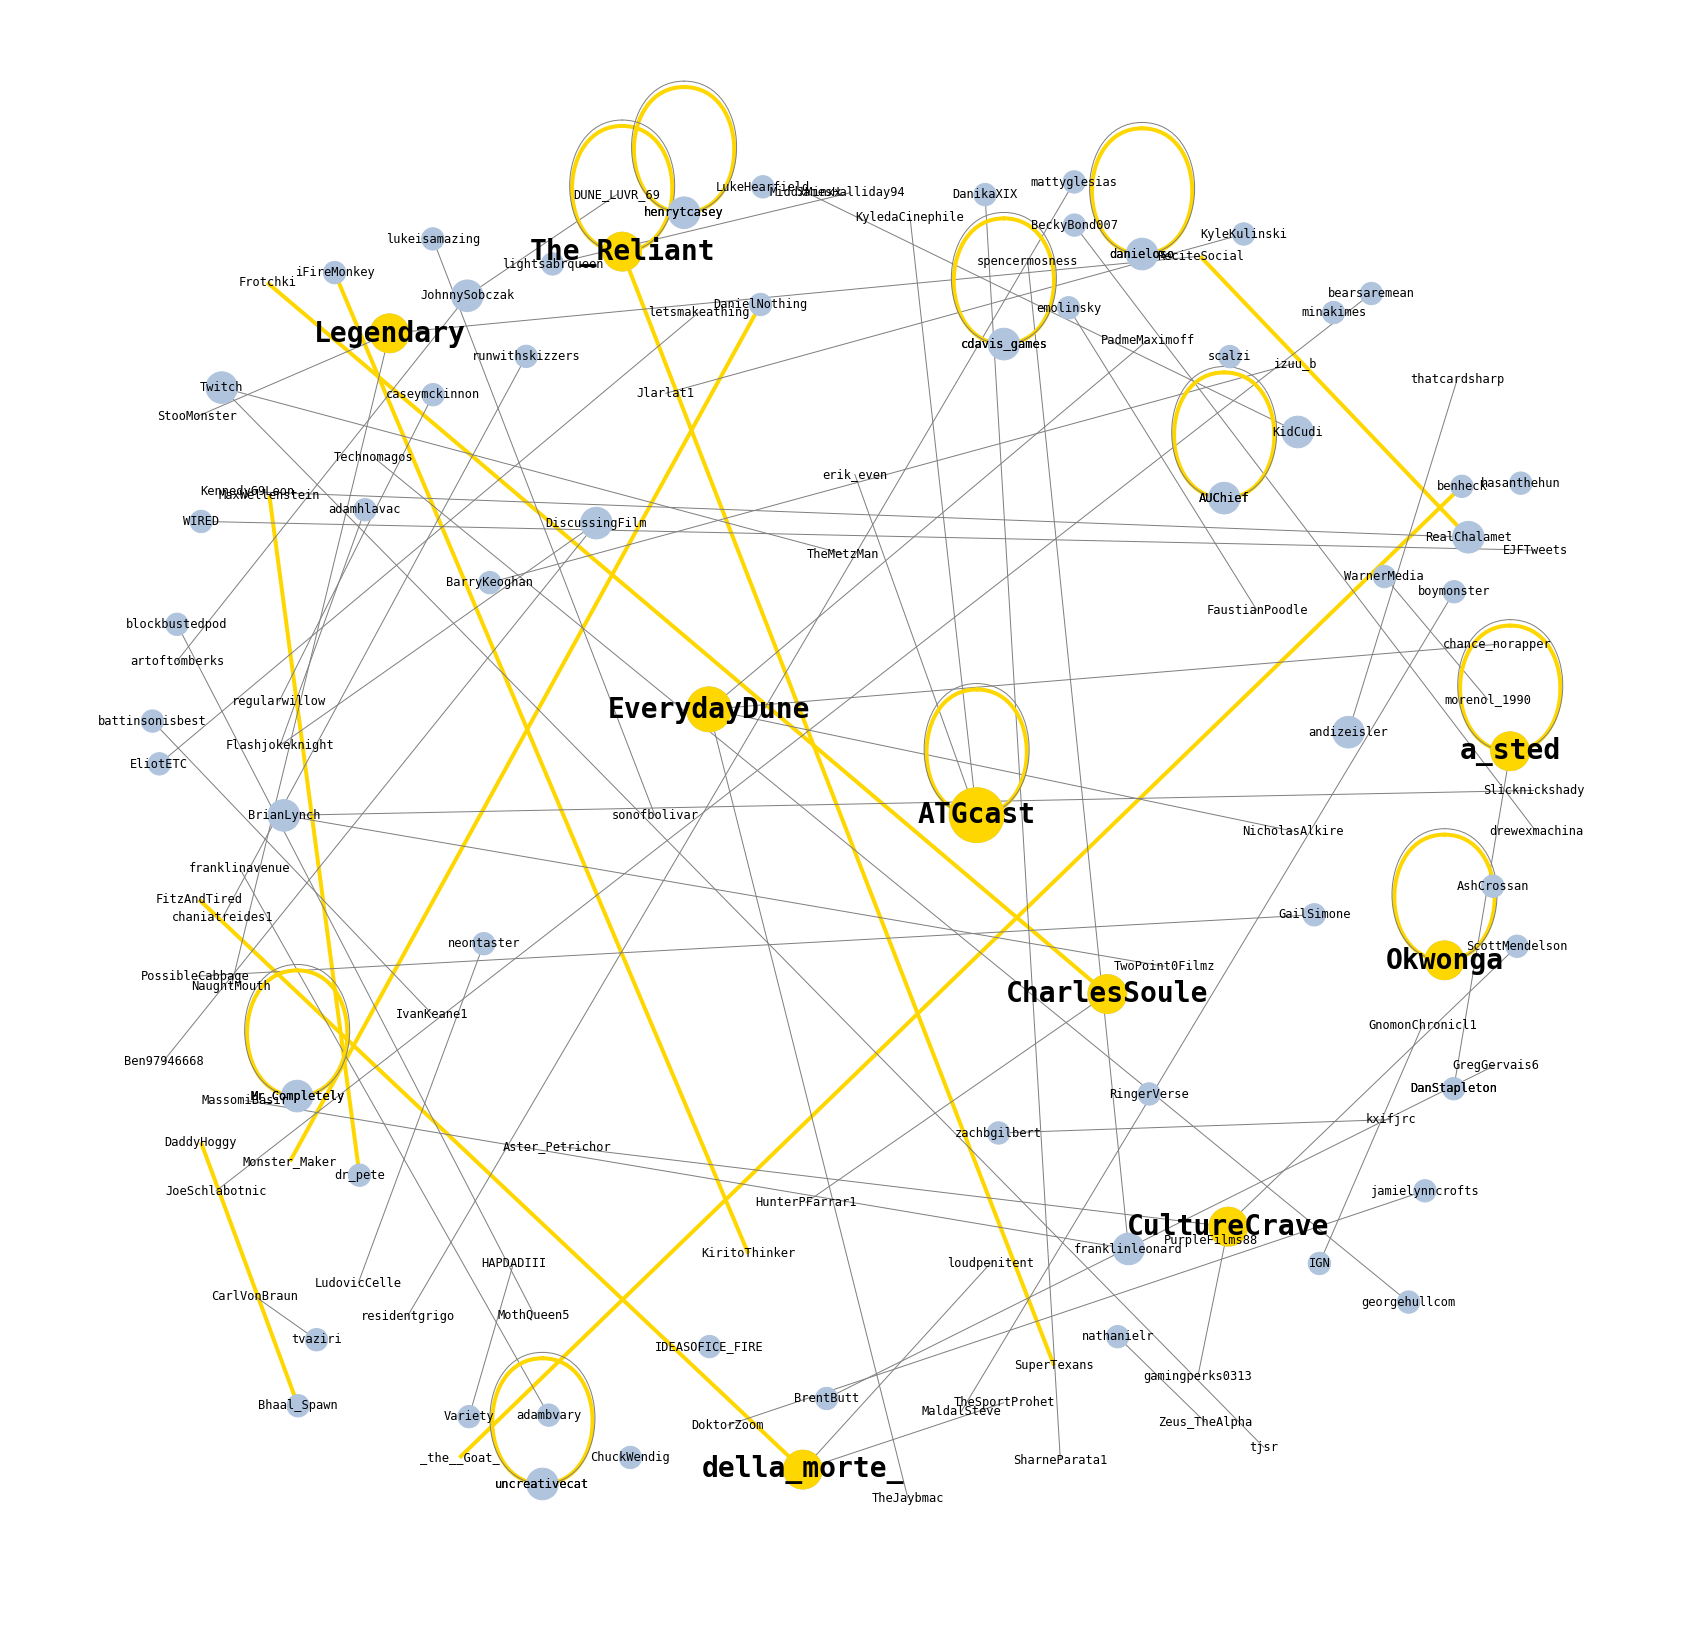

In [35]:
# Create network for all tweets
network_df = tweet_df[(tweet_df['username']!='Dune_in_Katy') & (tweet_df['in_reply_to_username']!='Dune_in_Katy')] # Remove username Dune_In_Katy because despite its popularity, it is not actually talking about Dune the movie.
network_df = network_df[network_df['in_reply_to_username'].notnull()]
network_df = network_df[['in_reply_to_username','username']].rename(columns={"in_reply_to_username": "source", "username": "target"})

# Input function get_network(df, pop_source_th, pop_target_th, edge_th, pop_person_th)
get_network(network_df, 3, 2, 2, 3)

# Mini report

Top 100 most common words
[('part', 1229), ('movie', 1066), ('like', 880), ('see', 687), ('good', 614), ('watch', 572), ('one', 527), ('two', 526), ('time', 459), ('really', 436), ('book', 418), ('get', 410), ('sequel', 405), ('read', 361), ('people', 361), ('watching', 357), ('film', 355), ('would', 354), ('know', 333), ('first', 329), ('going', 327), ('think', 316), ('na', 298), ('new', 297), ('seen', 293), ('dunemovie', 285), ('got', 279), ('watched', 275), ('even', 272), ('go', 269), ('much', 250), ('wait', 249), ('great', 245), ('movies', 241), ('amp', 230), ('way', 226), ('love', 226), ('want', 224), ('gon', 224), ('villeneuve', 223), ('2021', 223), ('still', 218), ('zendaya', 213), ('make', 208), ('could', 204), ('saw', 203), ('need', 202), ('books', 200), ('getting', 199), ('1x', 198), ('denis', 196), ('better', 190), ('also', 187), ('well', 185), ('paul', 182), ('2023', 181), ('say', 179), ('made', 178), ('spice', 178), ('years', 178), ('right', 172), ('seeing', 171), ('yet', 

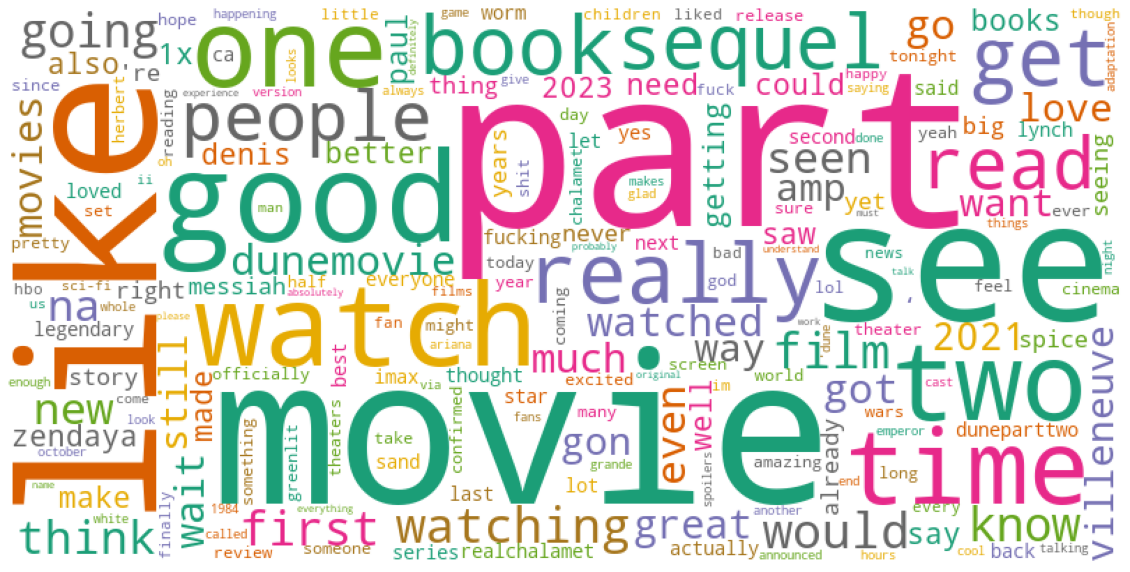

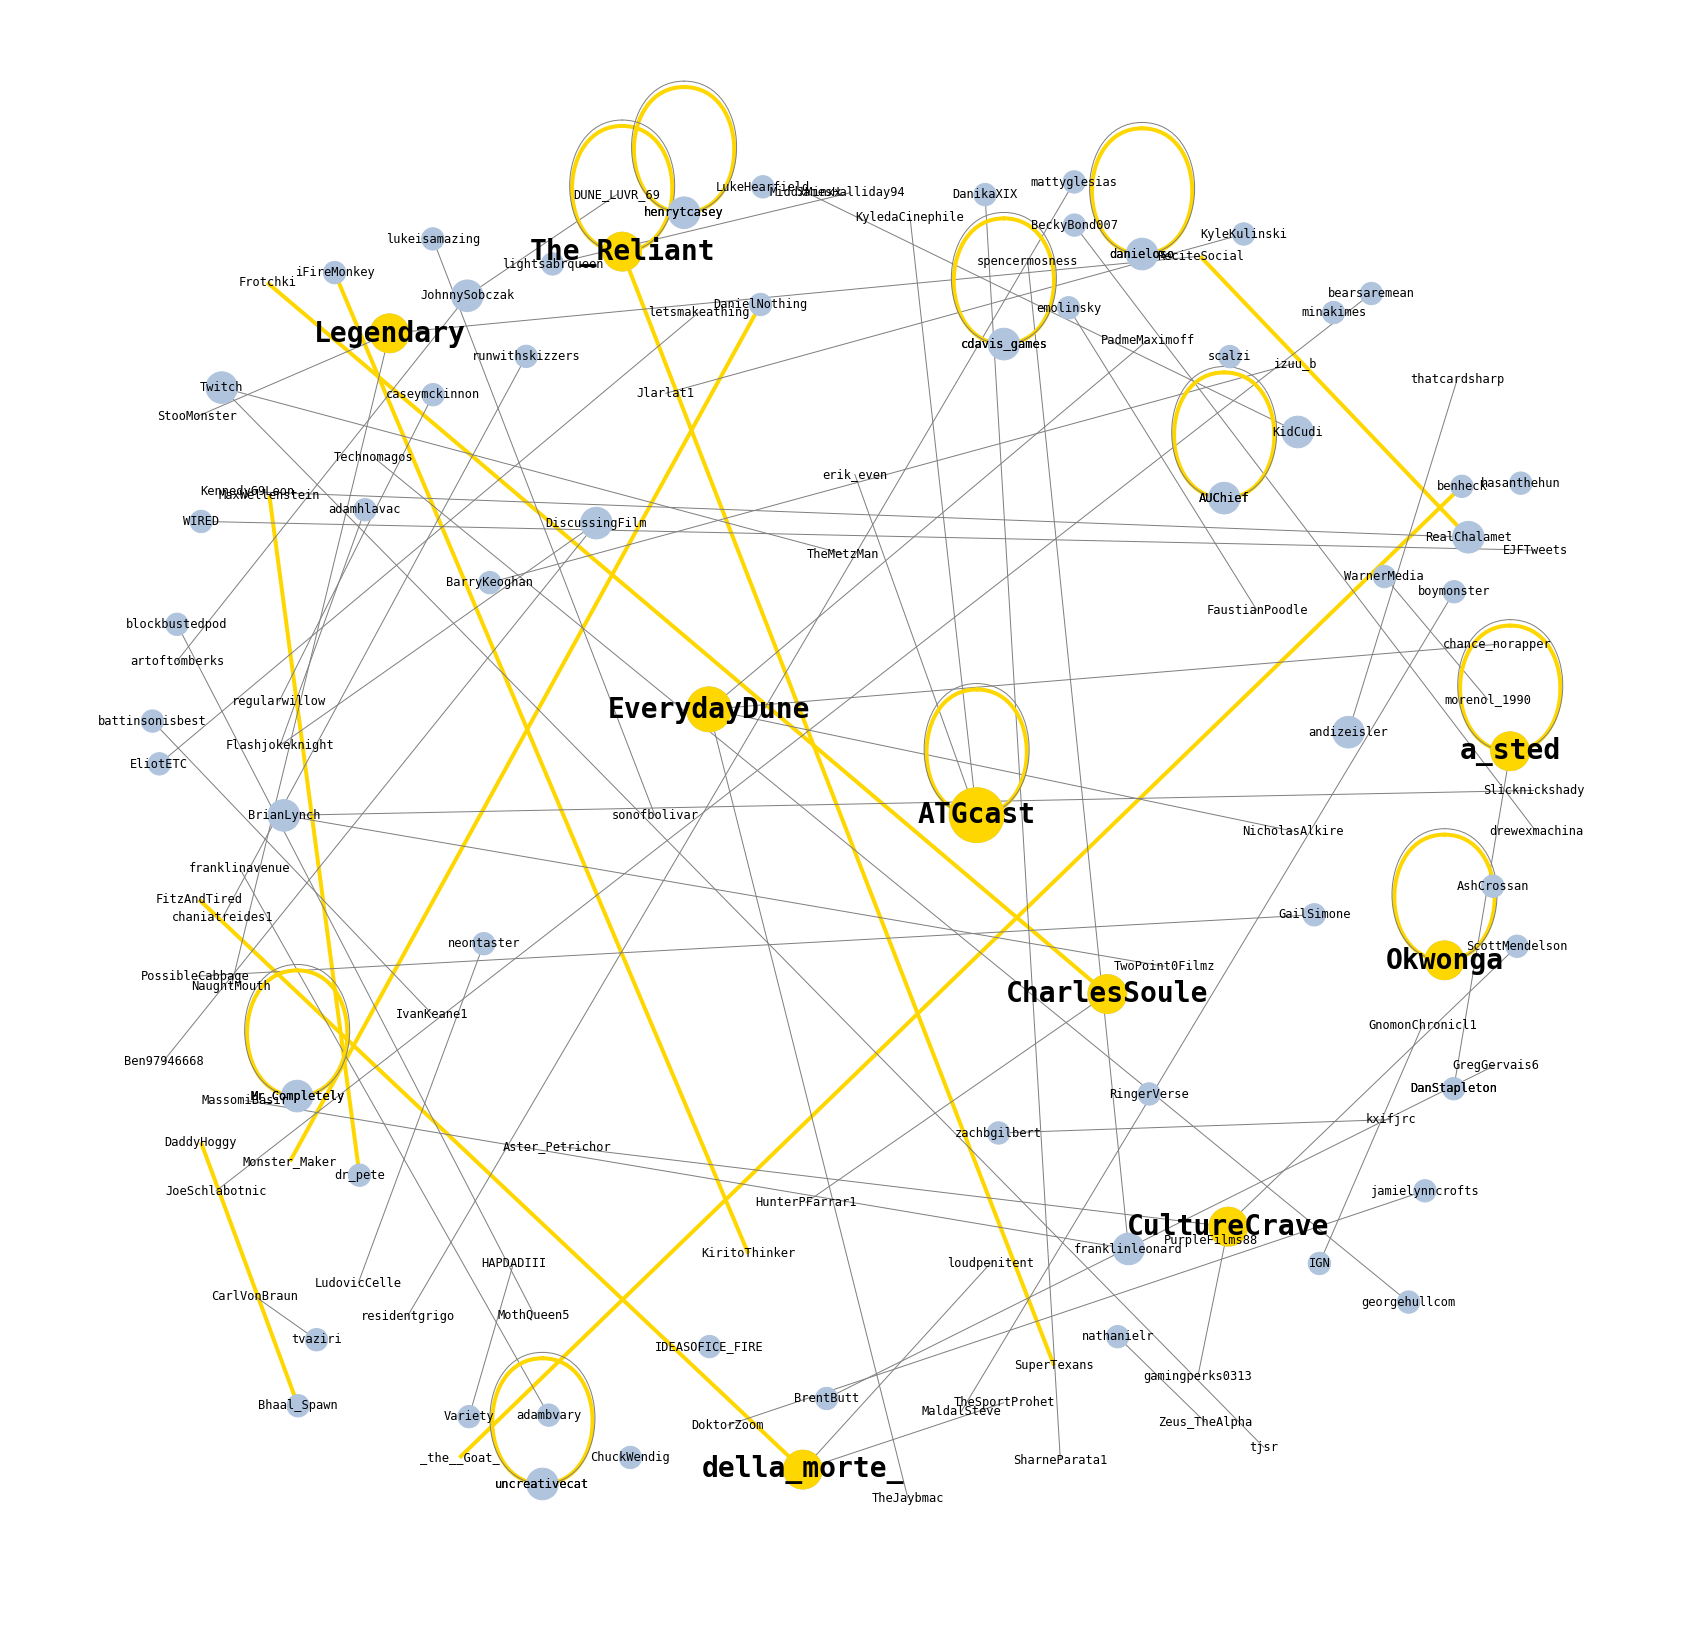

In [37]:
# Summarize sentiment analysis
fig_sentiment.show()

# Generate wordcloud for all tweets
generate_wordcloud(tweet_df['tweet'])

# Input function get_network(df, pop_source_th, pop_target_th, edge_th, pop_person_th)
get_network(network_df, 3, 2, 2, 3)

It is necessary for movie producers to understand how people perceive their movies. In this study, text mining techniques were applied to extract useful information that will help movie producers make better movies in the future. We gathered information from Twitter to evaluate the comments given to **the movie Dune**. After fetching 10.000 tweets with the word “dune” on it, a sentiment analysis was carried out. The comments of Dune on Twitter were mainly positive, with almost 4.400 tweets. Neutral comments accounted for almost 4.000 tweets while negative comments were only 1.500. Looking at the sentiment analysis, it seems that people enjoyed the movie. Besides, the most common words were “like”, “good”, “watch” and “see”, which also showed a positive reception towards the movie. We also ran a network analysis to evaluate how different users are connected to each other. The nodes represent the username, while the paths represent the number of replies between users. The most popular users were **@ATGCast**, **@Legendary**, **EverydayDune**, **CultureCrave**, indicated that these are the most effective channels to promote the movie. Overall, Dune had a positive reception among users and the overall reactionsto the movie were positive.